In [ ]:

!pip install nltk
!pip install tensorflow
!pip install sklearn
!pip install optuna
import os
import sqlite3
import pandas as pd
import nltk
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, LSTM, Bidirectional
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import pickle
import re
import random
import numpy as np
import matplotlib.pyplot as plt
import gc
import optuna
from sklearn.model_selection import train_test_split

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Загружаем базу данных.

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
db_name='/content/drive/MyDrive/disasm/main_database.sqlite'     
sqlite_db=sqlite3.connect(db_name)
dataBase = pd.read_sql('SELECT * FROM functions', sqlite_db)
sqlite_db.close()

In [ ]:
print(dataBase.head())

   id        name  address compiler options libname  \
0   1  .init_proc    12288      gcc     -O0    gzip   
1   2    sub_3020    12320      gcc     -O0    gzip   
2   3    sub_3030    12336      gcc     -O0    gzip   
3   4    sub_3040    12352      gcc     -O0    gzip   
4   5    sub_3050    12368      gcc     -O0    gzip   

                                            assembly  
0  endbr64; _init\nsub     rsp, 8\nmov     rax, c...  
1     push    cs:qword_18D58\nbnd jmp cs:qword_18D60  
2               endbr64\npush    0\nbnd jmp sub_3020  
3               endbr64\npush    1\nbnd jmp sub_3020  
4               endbr64\npush    2\nbnd jmp sub_3020  


In [ ]:
print(dataBase.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62339 entries, 0 to 62338
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        62339 non-null  int64 
 1   name      62339 non-null  object
 2   address   62339 non-null  int64 
 3   compiler  62339 non-null  object
 4   options   62339 non-null  object
 5   libname   62339 non-null  object
 6   assembly  62339 non-null  object
dtypes: int64(2), object(5)
memory usage: 3.3+ MB
None


In [ ]:
dbCountObjects = x_batch = dataBase['assembly'].count()   # Количество объектов в базе

Создаём словарь со словами из базы данных с ассемблерами

In [ ]:
tokenizer = Tokenizer(split=' ',char_level=False)       # Убираем символы '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', а разделителем слов является пробел
if (os.path.exists('/content/drive/MyDrive/disasm/TokenizedDictionary') == True):  # Если словарь уже создан - загружаем его
    with open('/content/drive/MyDrive/disasm/TokenizedDictionary', 'rb') as handle:
        tokenizer = pickle.load(handle)
else:                                                   # в противном случае - создаём словарь
        for i in range(dbCountObjects):
            text = re.sub("\d[A-Fa-f0-9]*[dhbqo]?", "digit", dataBase['assembly'][i])  #Заченяем числа всех систем счисления на "digit"
            text = re.sub("loc_[\w]*", "loc", text)       #Заченяем "loc_*" на "loc"
            text = re.sub("var_[\w]*", "var", text)       #Заченяем "var_*" на "var"
            tokenizer.fit_on_texts([text])                #Добавляем слова в словарь
            if (i % 1000 == 0):
                print(i)

In [ ]:
with open('/content/drive/MyDrive/disasm/TokenizedDictionary', 'wb') as handle:     # Сохранение словаря
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
word_indexes = tokenizer.word_index
print(word_indexes)

{'digit': 1, 'mov': 2, 'loc': 3, 'rax': 4, 'rdigit': 5, 'rbp': 6, 'var': 7, 'eax': 8, 'rdi': 9, 'short': 10, 'ptr': 11, 'call': 12, 'rbx': 13, 'rsp': 14, 'cmp': 15, 'jz': 16, 'rcx': 17, 'rdx': 18, 'test': 19, 'rsi': 20, 'jmp': 21, 'lea': 22, 'ecx': 23, 'edx': 24, 'add': 25, 'push': 26, 'jnz': 27, 'xor': 28, 'pop': 29, 'esi': 30, 'xmmdigit': 31, 'dword': 32, 'qword': 33, 'byte': 34, 'edi': 35, "'": 36, 'cs': 37, 'sub': 38, 'movzx': 39, 'al': 40, 'retn': 41, 'ebx': 42, 'ebp': 43, 'internal': 44, 'int': 45, 'alias': 46, 's': 47, 'and': 48, 'ctxt': 49, 'jumptable': 50, 'xmmword': 51, 'cl': 52, 'movsxd': 53, 'case': 54, 'endbrdigit': 55, 'n': 56, 'movups': 57, 'word': 58, 'dl': 59, 'nop': 60, 'name': 61, 'shl': 62, 'or': 63, 'ja': 64, 'jle': 65, 'error': 66, 'is': 67, 'xmlfree': 68, 'png': 69, 'ds': 70, 'shr': 71, 'jbe': 72, 'locret': 73, 'alternative': 74, 'xmlstrequal': 75, 'src': 76, 'cases': 77, 'intdigit': 78, 'jnb': 79, 'offset': 80, 'default': 81, 'jg': 82, 'cur': 83, 'format': 84, '

Подготовка данных для обучения:

Token max len =  25391


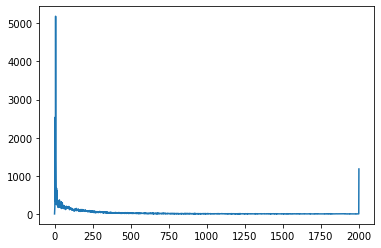

In [ ]:
 #Ищем максимальную длину токенизированного ассемблера и ищем минимальный порог токенов
maxLen = 0
X = range(2001)
Y = np.zeros(2001)
counter = 0
for i in range(dbCountObjects):
        text = re.sub("\d[A-Fa-f0-9]*[dhbqo]?", "digit", dataBase['assembly'][i])  #Заченяем числа всех систем счисления на "digit"
        text = re.sub("loc_[\w]*", "loc", text)                      #Заченяем "loc_*" на "loc"
        text = re.sub("var_[\w]*", "var", text)                      #Заченяем "var_*" на "var"
        textAsSequences = tokenizer.texts_to_sequences([text])[0]    #Заменяем слова на их токены
        tmp = len(textAsSequences)
        if (tmp < 2000):
            Y[tmp] += 1
        else: Y[2000]+=1
            #print(text, " assemb:", textAsSequences)
        if (tmp > maxLen):
            maxLen = tmp
plt.plot(X,Y)   # График: по X - кол-во токенов, Y - кол-во элементов с таким количеством токенов
# Ассемблеров до 10 токенов намного больше остальных, так как очень много однообразныъх коротких функций, поэтому ставим 
# минимальный порог равный 10 такенам
print("Token max len = ", maxLen)

In [ ]:
minTokens = 10    # Минимальный порог токенов
maxLen = 2000    # Максимальная длина ассемблера с токенизированными словами = 25391, но берём меньше, чтобы ускорить обучение и уменьшить расходуемую оперативную память
maxDim = 13600    # Размер словаря

In [ ]:
x_batch = np.zeros((dbCountObjects, maxLen))
y_batch = np.zeros(dbCountObjects)
counter = 0
for i in range(dbCountObjects):
    text = re.sub("\d[A-Fa-f0-9]*[dhbqo]?", "digit", dataBase['assembly'][i]) # Заменяем числа всех систем счисления на "digit"
    text = re.sub("loc_[\w]*", "loc", text)                           # Заменяем "loc_*" на "loc"
    text = re.sub("var_[\w]*", "var", text)                           # Заменяем "var_*" на "var"
    textAsSequences = tokenizer.texts_to_sequences([text])[0]         # Заменяем слова на их токены
    length = len(textAsSequences)  
    if (length > minTokens):                                          # Отсеиваем слишком маленькие функции                               
        if (length > maxLen):                                         # Обрезаем слишком большие функции
            length = maxLen                                      
        x_batch[counter, :length] = textAsSequences[:length]          # Добаляем токенизированный ассемблер в набор данных
        if dataBase['options'][i] == '-O0':                        # разбиваем на опции
            y_batch[counter] = 0
        elif dataBase['options'][i] == '-O1':
            y_batch[counter] = 1
        elif dataBase['options'][i] == '-O2':
            y_batch[counter] = 2
        elif dataBase['options'][i] == '-O3':
            y_batch[counter] = 3
        counter += 1
    if (i % 1000 == 0):
        print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000


In [ ]:
print(x_batch.shape)
print(y_batch.shape)
print("real count of objects = ", counter)

(62339, 2000)
(62339,)
real count of objects =  50484


Проектирование модели нейронной сети:

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_batch, y_batch, test_size=0.1)

In [ ]:
def build_model(params,maxLen=2000):
    model = Sequential()
    model.add(Embedding(input_dim=maxDim, output_dim=30, input_length=maxLen))#играть с output_dim? 
    model.add(Bidirectional(LSTM(units=params["units_bilstm"],
                    input_shape=(maxLen, 30),#если играть с output_dim, здесь тоже должно меняться
                    activation='tanh')))
    model.add(Dense(4, activation='softmax'))
    model.compile(
        optimizer=params["optimizer"],
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy'])
    return model

In [ ]:
def objective(trial):
  params={
      "units_bilstm":trial.suggest_int("units_bilstm",1,25),
      "optimizer":trial.suggest_categorical("optimizer",['adam','rmsprop','SGD'])
  }

  x_train_train, x_train_val, y_train_train, y_train_val = train_test_split(x_train, y_train, test_size=0.2)
  model=build_model(params)
  model.fit(x_train_train, y_train_train, epochs=8,batch_size=256)
  return model.evaluate(x_train_val,y_train_val,batch_size=256)[1]


In [ ]:
study=optuna.study.create_study(direction="maximize")
study.optimize(objective,n_trials=75,show_progress_bar=True)

[I 2022-06-29 12:37:22,319] A new study created in memory with name: no-name-1e6e7dc1-d819-4741-b7d5-96e273799018
/usr/local/lib/python3.7/dist-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 1/8
176/176 [==============================] - 29s 123ms/step - loss: 1.3142 - accuracy: 0.4171
Epoch 2/8
176/176 [==============================] - 22s 123ms/step - loss: 1.2577 - accuracy: 0.4228
Epoch 3/8
176/176 [==============================] - 22s 128ms/step - loss: 1.1794 - accuracy: 0.4298
Epoch 4/8
176/176 [==============================] - 22s 127ms/step - loss: 1.0624 - accuracy: 0.5207
Epoch 5/8
176/176 [==============================] - 22s 123ms/step - loss: 0.9816 - accuracy: 0.5516
Epoch 6/8
176/176 [==============================] - 22s 127ms/step - loss: 0.9358 - accuracy: 0.5649
Epoch 7/8
176/176 [==============================] - 22s 123ms/step - loss: 0.9002 - accuracy: 0.5743
Epoch 8/8
44/44 [==============================] - 3s 57ms/step - loss: 0.8583 - accuracy: 0.5897
[I 2022-06-29 12:40:55,258] Trial 0 finished with value: 0.5896978974342346 and parameters: {'units_bilstm': 18, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.5896978974342346.
Epoch 

In [ ]:
print(study.best_params)
print(study.best_value)

{'units_bilstm': 23, 'optimizer': 'adam'}
0.6773014664649963


In [ ]:
units_bilstm,optimizer=study.best_params['units_bilstm'],study.best_params['optimizer']
print(units_bilstm,optimizer)

In [ ]:

units_bilstm=23
optimizer='adam'


In [ ]:
a1 = Embedding(
    input_dim=maxDim, output_dim=30, input_length=maxLen)
a2 = Bidirectional(LSTM(units_bilstm, input_shape=(maxLen, 30),activation='tanh'))
a3 = Dense(4, activation='softmax')

model = Sequential()
model.add(a1)          
model.add(a2)          
#model.add(Flatten())
model.add(a3)

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer= optimizer, metrics=['accuracy'])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_batch, y_batch, test_size=0.1)

In [ ]:
test_accuracy = []
test_loss = []
class metrics_on_test(keras.callbacks.Callback):
    def __init__(self, model, x_test, y_test):
        self.model = model
        self.x_test = x_test
        self.y_test = y_test

    def on_epoch_end(self, epoch, logs={}):
        metrics_test = self.model.evaluate(self.x_test, self.y_test, batch_size=256)
        test_loss.append(metrics_test[0])
        test_accuracy.append(metrics_test[1])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2000, 30)          408000    
                                                                 
 bidirectional (Bidirectiona  (None, 46)               9936      
 l)                                                              
                                                                 
 dense (Dense)               (None, 4)                 188       
                                                                 
Total params: 418,124
Trainable params: 418,124
Non-trainable params: 0
_________________________________________________________________


In [ ]:
x_train_train, x_train_val, y_train_train, y_train_val = train_test_split(x_train, y_train, test_size=0.2)
test_accuracy = []
test_loss = []

history = model.fit(x_train_train,
                    y_train_train,
                    batch_size=256,
                    epochs=1000,
                    callbacks=
                      [EarlyStopping(monitor='loss', min_delta=0.0001, mode='min', patience=3),
                      metrics_on_test(model,x_train_val,y_train_val),
                      ReduceLROnPlateau(monitor="loss",factor=0.5, patience=1, min_lr=0.0001)])

Epoch 1/1000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


176/176 [==============================] - 34s 156ms/step - loss: 0.9391 - accuracy: 0.5561 - lr: 0.0010
Epoch 2/1000
176/176 [==============================] - 25s 143ms/step - loss: 0.7370 - accuracy: 0.6305 - lr: 0.0010
Epoch 3/1000
176/176 [==============================] - 27s 155ms/step - loss: 0.7039 - accuracy: 0.6479 - lr: 0.0010
Epoch 4/1000
176/176 [==============================] - 26s 149ms/step - loss: 0.6756 - accuracy: 0.6606 - lr: 0.0010
Epoch 5/1000
176/176 [==============================] - 25s 144ms/step - loss: 0.6565 - accuracy: 0.6709 - lr: 0.0010
Epoch 6/1000
176/176 [==============================] - 25s 144ms/step - loss: 0.6418 - accuracy: 0.6785 - lr: 0.0010
Epoch 7/1000
176/176 [==============================] - 25s 144ms/step - loss: 0.6255 - accuracy: 0.6876 - lr: 0.0010
Epoch 8/1000
176/176 [==============================] - 25s 144ms/step - loss: 0.6106 - accuracy: 0.6922 - lr: 0.0010
Epoch 9/1000
176/176 [==============================] - 26s 148ms/ste

In [ ]:
best_epoch = test_accuracy.index(max(test_accuracy))+1
print(test_accuracy)
print(test_loss)
print('Best epoch: %d' % (best_epoch,))

[0.624988853931427, 0.6347028017044067, 0.6473576426506042, 0.6580518484115601, 0.6571606993675232, 0.6630424857139587, 0.6670528650283813, 0.6748952865600586, 0.6718652248382568, 0.674004077911377, 0.6789947152137756, 0.6788164973258972, 0.67097407579422, 0.6836289167404175, 0.6802424192428589, 0.6816682815551758, 0.682292103767395, 0.682292103767395, 0.6822029948234558, 0.6814009547233582, 0.660101592540741, 0.678727388381958, 0.6789056062698364]
[0.7557725310325623, 0.7192075848579407, 0.6998926401138306, 0.6766417026519775, 0.6687109470367432, 0.6651516556739807, 0.6589321494102478, 0.6450713872909546, 0.6507230997085571, 0.6404132843017578, 0.638739824295044, 0.6404280662536621, 0.6461009383201599, 0.6355507373809814, 0.640825629234314, 0.6370867490768433, 0.6439725756645203, 0.6394887566566467, 0.6414306163787842, 0.6392654776573181, 0.6595394015312195, 0.648842990398407, 0.6502257585525513]
Best epoch: 14


In [ ]:
a1 = Embedding(
    input_dim=maxDim, output_dim=30, input_length=maxLen)
a2 = Bidirectional(LSTM(units_bilstm, input_shape=(maxLen, 30),activation='tanh'))
a3 = Dense(4, activation='softmax')

hypermodel = Sequential()
hypermodel.add(a1)          
hypermodel.add(a2)          
#model.add(Flatten())
hypermodel.add(a3)

hypermodel.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer= optimizer, metrics=['accuracy'])
hypermodel.fit(x_train, y_train, epochs=best_epoch,batch_size=256)

Epoch 1/14


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


220/220 [==============================] - 31s 128ms/step - loss: 0.8948 - accuracy: 0.5710
Epoch 2/14
220/220 [==============================] - 30s 138ms/step - loss: 0.7282 - accuracy: 0.6304
Epoch 3/14
220/220 [==============================] - 28s 129ms/step - loss: 0.6914 - accuracy: 0.6519
Epoch 4/14
220/220 [==============================] - 28s 128ms/step - loss: 0.6629 - accuracy: 0.6676
Epoch 5/14
220/220 [==============================] - 28s 129ms/step - loss: 0.6402 - accuracy: 0.6814
Epoch 6/14
220/220 [==============================] - 28s 129ms/step - loss: 0.6726 - accuracy: 0.6646
Epoch 7/14
220/220 [==============================] - 30s 135ms/step - loss: 0.6556 - accuracy: 0.6722
Epoch 8/14
220/220 [==============================] - 28s 129ms/step - loss: 0.6346 - accuracy: 0.6806
Epoch 9/14
220/220 [==============================] - 28s 128ms/step - loss: 0.6062 - accuracy: 0.6961
Epoch 10/14
220/220 [==============================] - 30s 135ms/step - loss: 0.5935

In [ ]:
loss_metric_test = hypermodel.evaluate(x_test,y_test,batch_size=256)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


25/25 [==============================] - 2s 61ms/step - loss: 0.6428 - accuracy: 0.6793


In [ ]:
hypermodel.save("my_model.h5")